In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
dt = 0.004
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

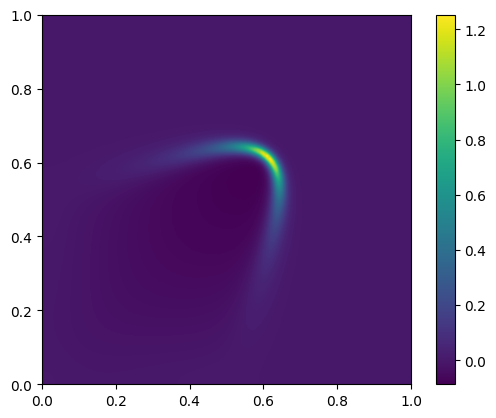

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = u_dot

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

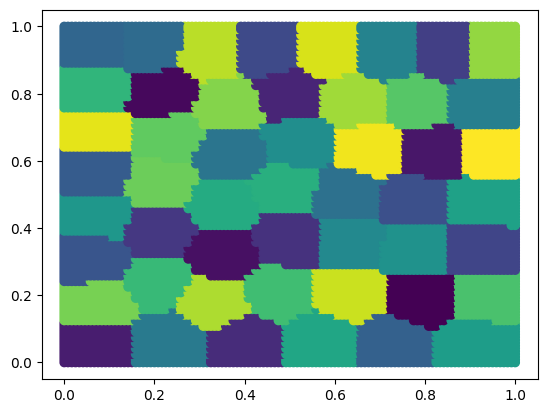

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [10]:
group_indices = []
for i in range(m):
    group_indices.append(torch.tensor(np.where(clustering.labels_ == i)[0], device=device))

In [11]:
N = datas.shape[1]
n = 20
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [12]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [13]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbours=neighbours, group_indices=group_indices, device=device)

In [14]:
encoded = ed.nrbs.encode(datas[:15].to(device))

In [15]:
encoded.shape

torch.Size([15, 20])

In [16]:
decoded = ed.nrbs.decode(encoded)

In [17]:
decoded.shape

torch.Size([15, 14641])

In [18]:
ed.train(train_data_loader=train_data, epochs=500)

100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


Itr 0, loss = 39332.29473131252


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


Itr 1, loss = 21904.041805369634


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 2, loss = 12708.500151290162


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


Itr 3, loss = 7923.170462803054


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


Itr 4, loss = 5262.9509869219055


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


Itr 5, loss = 3814.5093420737644


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


Itr 6, loss = 3160.9393388852473


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


Itr 7, loss = 2564.1872127817196


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Itr 8, loss = 2195.716468590923


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


Itr 9, loss = 1936.3582004347181


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Itr 10, loss = 1879.4572933224008


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


Itr 11, loss = 1733.6751839839087


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


Itr 12, loss = 1540.6944824016352


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


Itr 13, loss = 1443.1267033396468


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 14, loss = 1304.39172171238


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Itr 15, loss = 1231.9034788442104


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Itr 16, loss = 1153.144045096835


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Itr 17, loss = 1155.546840805659


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Itr 18, loss = 1047.4305721072694


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 19, loss = 975.6873463771379


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 20, loss = 922.8569069093166


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 21, loss = 893.874216287702


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 22, loss = 859.8022668531837


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 23, loss = 850.2640175707143


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 24, loss = 850.2139410110901


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 25, loss = 858.8059682650968


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


Itr 26, loss = 909.0402588548764


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


Itr 27, loss = 965.7863303403797


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


Itr 28, loss = 1086.7275694610244


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 29, loss = 1832.8651124717792


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 30, loss = 1536.7292358782302


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 31, loss = 878.4976223860801


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 32, loss = 764.1547214058916


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 33, loss = 649.1530916721911


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 34, loss = 639.8592561062044


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 35, loss = 670.1582083814828


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


Itr 36, loss = 603.0674304707467


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 37, loss = 579.86271716297


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


Itr 38, loss = 605.9616852190195


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 39, loss = 589.8049385284374


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 40, loss = 576.0002698579483


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 41, loss = 622.9572323983203


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 42, loss = 683.2243264226123


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 43, loss = 679.7370069001299


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 44, loss = 674.9882485901074


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 45, loss = 600.8417815710623


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Itr 46, loss = 599.6364255062533


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Itr 47, loss = 575.7914859834126


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 48, loss = 574.1369030281869


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 49, loss = 564.6645882025477


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 50, loss = 772.9685260780169


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 51, loss = 850.1710241599314


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 52, loss = 967.5392558591326


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 53, loss = 768.1260264113823


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 54, loss = 705.1382086941115


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 55, loss = 602.3877126388475


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 56, loss = 613.1318139809371


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 57, loss = 577.6703871910851


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 58, loss = 524.0077081683867


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 59, loss = 503.92119726681364


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 60, loss = 575.4675856426649


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 61, loss = 577.8865892739111


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 62, loss = 586.8874908271611


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 63, loss = 651.7218534498971


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 64, loss = 672.1460999381546


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 65, loss = 631.54971422774


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 66, loss = 775.0107064139233


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 67, loss = 691.5259623701634


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 68, loss = 645.3249789226128


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 69, loss = 752.5335113442907


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 70, loss = 713.4064016156295


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 71, loss = 588.2792335801104


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 72, loss = 592.624858601859


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


Itr 73, loss = 553.2975551071937


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


Itr 74, loss = 542.7741105035032


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


Itr 75, loss = 489.8978255391349


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 76, loss = 439.85891101260995


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


Itr 77, loss = 427.1314138719599


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


Itr 78, loss = 424.1127307427057


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


Itr 79, loss = 417.8449303062434


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


Itr 80, loss = 437.22623851929416


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 81, loss = 502.40403138085935


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 82, loss = 485.6720223075191


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 83, loss = 534.2442716675805


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 84, loss = 564.559167664308


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 85, loss = 455.8191689379783


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 86, loss = 425.0132549843055


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 87, loss = 435.1450752032278


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 88, loss = 414.14654145007097


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 89, loss = 409.8084443500422


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 90, loss = 487.4875405111335


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 91, loss = 857.1870493409322


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 92, loss = 1050.9701104966796


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 93, loss = 1231.535479304183


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 94, loss = 873.6844685834714


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 95, loss = 854.920547393811


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Itr 96, loss = 955.8670684839707


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Itr 97, loss = 801.7392416665023


 56%|█████▌    | 14/25 [00:38<00:30,  2.77s/it]


KeyboardInterrupt: 

In [ ]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [19]:
approximates = ed(datas[499:501].to(device))
approximates.shape

torch.Size([1, 14641])

In [20]:
approximates[0]

tensor([-5.3784e-03, -6.4047e-03, -5.9035e-03,  ...,  1.4393e-04,
         1.1797e-04,  2.7509e-05], device='cuda:0', grad_fn=<SelectBackward0>)

In [21]:
datas[489]

tensor([2.5750e-03, 2.4500e-03, 2.3000e-03,  ..., 6.4447e-30, 6.4447e-30,
        9.2545e-30])

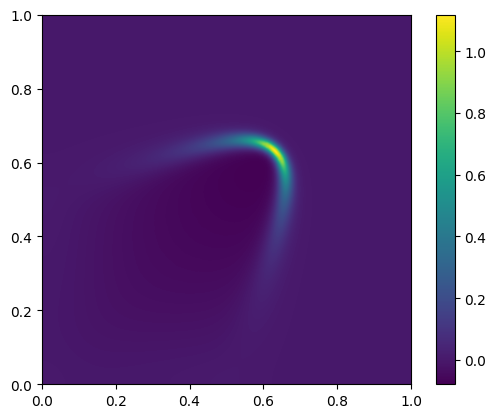

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[499].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

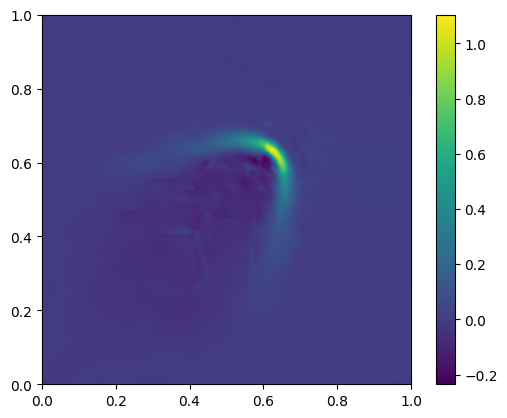

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

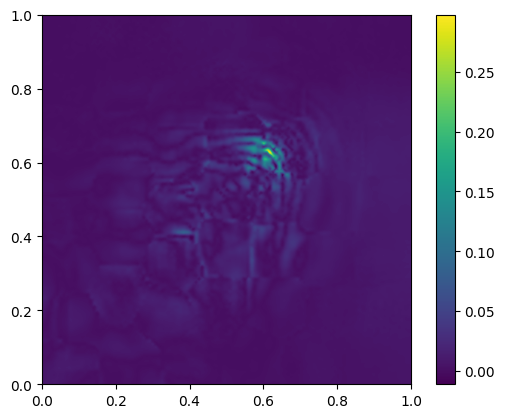

In [24]:
err = abs(datas[499] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [26]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()